In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils


In [12]:
# path = os.path.realpath(__file__).split('/')
path =os.getcwd().split('/')
root = os.path.join(*path[0:-2])
root


'mnt/neurocube/local/serenceslab/maggie/shapeDim'

In [2]:
from decoding import decode_multiclass
decode_multiclass.decode_allmaintask(debug=False)

loading S01, main task
loading S02, main task
loading S03, main task
missing voxel_inds for IPS2 lh
loading S04, main task
loading S05, main task
loading S06, main task
loading S07, main task
proc S01, V1
0
    cv fold 0: best c = 0.00207, max acc = 0.23
proc S02, V1
0
    cv fold 0: best c = 0.00695, max acc = 0.35
proc S03, V1
0
    cv fold 0: best c = 0.07848, max acc = 0.26
proc S04, V1
0
    cv fold 0: best c = 0.00207, max acc = 0.33
proc S05, V1
0
    cv fold 0: best c = 0.02336, max acc = 0.49
proc S06, V1
0
    cv fold 0: best c = 0.00207, max acc = 0.46
proc S07, V1
0
    cv fold 0: best c = 0.00695, max acc = 0.20


In [4]:
saved_filename = os.path.join(root, 'Analysis', 'decoding_results', 'decode_multiclass_allmaintask.npy')
d = np.load(saved_filename, allow_pickle=True).item()
d.keys()

dict_keys(['acc_overall', 'dprime_overall', 'acc_each_point', 'dprime_each_point', 'num_preds', 'acc_each_cval', 'best_cval'])

In [54]:
debug = False
ri = 1
debug & (ri>0)

False

In [2]:
subjects = np.arange(1,8)
n_subj = len(subjects)
n_rois = 11
make_time_resolved=False

# first load all data for all subjects, both tasks
maindat_all = []; repdat_all = []
mainlabs_all = []; replabs_all = []

for si, ss in enumerate(subjects):
    # si = 0; ss = 1;

    print('loading S%02d, main task'%ss)
    main_data, _, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        main_data[ri] -= np.tile(np.mean(main_data[ri], axis=1, keepdims=True), [1, main_data[ri].shape[1]])

    maindat_all += [main_data]
    mainlabs_all += [main_labels]

    print('loading S%02d, repeat task'%ss)
    rep_data, _, rep_labels, roi_names = data_utils.load_repeat_task_data(ss, make_time_resolved)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        rep_data[ri] -= np.tile(np.mean(rep_data[ri], axis=1, keepdims=True), [1, rep_data[ri].shape[1]])

    repdat_all += [rep_data]
    replabs_all += [rep_labels]

loading S01, main task
loading S01, repeat task
loading S02, main task
loading S02, repeat task
loading S03, main task
missing voxel_inds for IPS2 lh
loading S03, repeat task
missing voxel_inds for IPS2 lh
loading S04, main task
loading S04, repeat task
loading S05, main task
loading S05, repeat task
loading S06, main task
loading S06, repeat task
loading S07, main task
loading S07, repeat task


In [9]:
subjects = np.arange(1,8)
n_subjects = len(subjects)
n_rois = 11;
n_grid_pts = 16;

# penalties to eval
c_values = np.logspace(-9, 1, 20)

# si = 0;
si = 1;
ri = 0;
# ti = 0;

main_data = maindat_all[si]
main_labels = mainlabs_all[si]

rep_data = repdat_all[si]
rep_labels = replabs_all[si]

# pull out data from main grid trials only, this task
# inds_use = (main_labels['is_main_grid']==True) & (main_labels['task']==ti+1)
inds_use = (main_labels['is_main_grid']==True) 

dat = main_data[ri][inds_use,:]

# labels are 1-16 for grid positions
xlabs = np.array(main_labels['ptx'])[inds_use]
ylabs = np.array(main_labels['pty'])[inds_use]
pt_labs = np.array([xlabs, ylabs]).T
grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, return_inverse=True, return_counts=True)
assert(len(grid_pts)==n_grid_pts)

cv_labs = np.array(main_labels['run_overall'])[inds_use]
n_cv = len(np.unique(cv_labs))

In [10]:
cv_obj = sklearn.model_selection.LeaveOneGroupOut()
cv_generator = cv_obj.split(dat, grid_labs, cv_labs)

# define model
model = sklearn.linear_model.LogisticRegressionCV(cv = cv_generator, \
                                                Cs = c_values, \
                                                multi_class='multinomial',\
                                                solver='lbfgs', \
                                                penalty='l2', \
                                                n_jobs = 8 )

model.fit(dat, grid_labs)

LogisticRegressionCV(Cs=array([1.00000000e-09, 3.35981829e-09, 1.12883789e-08, 3.79269019e-08,
       1.27427499e-07, 4.28133240e-07, 1.43844989e-06, 4.83293024e-06,
       1.62377674e-05, 5.45559478e-05, 1.83298071e-04, 6.15848211e-04,
       2.06913808e-03, 6.95192796e-03, 2.33572147e-02, 7.84759970e-02,
       2.63665090e-01, 8.85866790e-01, 2.97635144e+00, 1.00000000e+01]),
                     cv=<generator object BaseCrossValidator.split at 0x7f4d0b7c7650>,
                     multi_class='multinomial', n_jobs=8)

In [11]:
best_acc = [np.max(model.scores_[0][cv,:]) for cv in range(len(np.unique(cv_labs)))]
np.mean(best_acc)

0.3845486111111111

In [15]:
best_acc = np.max(np.mean(model.scores_[0], axis=0))
best_acc

0.35714285714285715

In [33]:
# average performance, each roi and subject
acc_overall = np.zeros((n_subjects, n_rois))
dprime_overall = np.zeros((n_subjects, n_rois))
# performance broken down by points in the grid
acc_each_point = np.zeros((n_subjects, n_rois, n_grid_pts)) 
dprime_each_point = np.zeros((n_subjects, n_rois, n_grid_pts)) 

# count individual predictions, to get confusability of categories
num_preds = np.zeros((n_subjects, n_rois, n_grid_pts, n_grid_pts)) 

In [26]:

for cvi, cv in enumerate(np.unique(cv_labs)):
   
    # holding out one run at a time as a test set
    trninds = cv_labs!=cv
    tstinds = cv_labs==cv

    trndat = dat[trninds,:]
    tstdat = dat[tstinds,:]
    trnlabs = grid_labs[trninds]
    tstlabs = grid_labs[tstinds]

    # now going to do regularization parameter (c) selection
    # this is based on training data only, for the current fold.
    # cross-validate using leave-one-run-out (for just the training runs here)
    nest_cv_labs = cv_labs[trninds]
    nest_cv_obj = sklearn.model_selection.LeaveOneGroupOut()
    nest_cv_generator = cv_obj.split(trndat, trnlabs, nest_cv_labs)

    print(cvi)
    # define model
    model = sklearn.linear_model.LogisticRegressionCV(cv = nest_cv_generator, \
                                                    Cs = c_values, \
                                                    multi_class='multinomial',\
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = 8 )
    model.fit(trndat, trnlabs)

    # pull out the accuracy of the model for each C value
    # averaging across the nested CV folds
    a = np.mean(model.scores_[0], axis=0)
    c = model.C_[0]
    assert(c_values[np.argmax(a)]==c)
    
    print('cv fold %d: best c = %.5f, max acc = %.2f'%(cvi, c, np.max(a)))
    acc_each_cval[cvi,:] = a
    best_cval[cvi] = c
    
    # finally, predict on the held-out test data here
    pred = model.predict(tstdat)
    
    pred_labs[tstinds] = pred
    
    

In [34]:
# compute some performance metrics
acc_overall[si,ri] = np.mean(pred_labs==grid_labs)
dprime_overall[si,ri] = stats_utils.get_dprime(pred_labs, grid_labs)

# performance for individual categories (grid pos)
for gi, gg in enumerate(np.unique(grid_labs)):
    
    # for the trials in categ gg, how often did classifier label correctly (hit rate)?
    inds = grid_labs==gg 
    acc_each_point[si,ri,gi] = np.mean(pred_labs[inds]==grid_labs[inds])
    # for d-prime, we are going to use all the trials, but re-label them as binary 
    # for the category of interest. so it captures how well the classifier 
    # can discriminate this category versus others.
    pred_labs_binary = (pred_labs==gg).astype(int)
    grid_labs_binary = (grid_labs==gg).astype(int)
    dprime_each_point[si,ri,gi] = stats_utils.get_dprime(pred_labs_binary, grid_labs_binary)

    # now computing confusability of diff categories 
    for gi2, gg2 in enumerate(np.unique(grid_labs)):
        inds = (grid_labs==gg) & (pred_labs==gg2)
        num_preds[si, ri, gi, gi2] = np.sum(inds)
        
    assert(np.sum(num_preds[si,ri,gi,:])==np.sum(grid_labs==gg))

In [47]:
n = num_preds[si,ri,:,:]
s = np.tile(np.sum(n, axis=1, keepdims=True), [1,n.shape[1]])
prop_conf =  n/s

In [49]:
np.sum(prop_conf, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Text(0.5, 0, 'pred label')

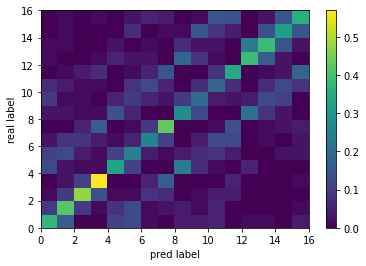

In [50]:
# prop_conf[2,5] = 100
plt.figure()
plt.pcolormesh(prop_conf)
plt.colorbar()
plt.ylabel('real label')
plt.xlabel('pred label')

In [17]:
pred_labs.shape

(1152,)

In [20]:
grid_labs

array([ 5,  9, 11, ..., 15, 15, 12])

1.306953073434993

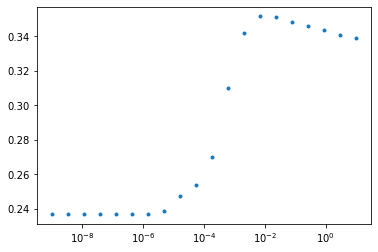

In [16]:
plt.figure()
plt.plot(c_values, np.mean(acc_each_cval, axis=0), '.')
plt.gca().set_xscale('log')

In [148]:
# store which c value is best
acc_all = np.zeros((n_cv, len(c_values)))
acc_each_cval = np.zeros((len(c_values),))

for ci, c in enumerate(c_values):

    
    predlabs = np.zeros(np.shape(grid_labs))

    for cvi, cv in enumerate(np.unique(cv_labs)):
    
        print(ci, cvi)
        trninds = cv_labs!=cv
        tstinds = cv_labs==cv

        trndat = dat[trninds,:]
        tstdat = dat[tstinds,:]
        trnlabs = grid_labs[trninds]
        tstlabs = grid_labs[tstinds]
        
        # define model
        model = sklearn.linear_model.LogisticRegression(C = c, \
                                                        multi_class='multinomial',\
                                                        solver='lbfgs', \
                                                        penalty='l2', \
                                                        n_jobs = 8 )
        
        model.fit(trndat, trnlabs)
        pred = model.predict(tstdat)
        
        acc_all[cvi, ci] = np.mean(pred==tstlabs)

        predlabs[tstinds] = pred

    acc_each_cval[ci] = np.mean(predlabs==grid_labs)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
5 31


In [137]:
np.mean(model.scores_[0])

0.20911458333333333

In [129]:
pred = model.predict(tstdat)
    
# pull out the accuracy of the model for each C value
# averaging across the nested CV folds
a = np.mean(model.scores_[0], axis=0)
c = model.C_[0]
assert(c_values[np.argmax(a)]==c)
    
print('cv fold %d: best c = %.5f, max acc = %.2f'%(cvi, c, np.max(a)))
    acc_each_cval[cvi,:] = a
    best_cval[cvi] = c
    
    p
    pred_labs[tstinds] = pred
    
acc = np.mean(pred_labs==grid_labs)
print(acc)

0
cv fold 0: best c = 0.00207, max acc = 0.23
1
cv fold 1: best c = 0.00207, max acc = 0.25
2
cv fold 2: best c = 0.00695, max acc = 0.25
3
cv fold 3: best c = 0.00207, max acc = 0.26
4
cv fold 4: best c = 0.00207, max acc = 0.24
5
cv fold 5: best c = 0.00207, max acc = 0.23
6
cv fold 6: best c = 0.00695, max acc = 0.24
7
cv fold 7: best c = 0.00207, max acc = 0.24
8
cv fold 8: best c = 0.02336, max acc = 0.24
9
cv fold 9: best c = 0.00695, max acc = 0.24
10
cv fold 10: best c = 0.00695, max acc = 0.23
11
cv fold 11: best c = 0.00207, max acc = 0.24
12
cv fold 12: best c = 0.00207, max acc = 0.24
13
cv fold 13: best c = 0.00207, max acc = 0.25
14
cv fold 14: best c = 0.00207, max acc = 0.24
15
cv fold 15: best c = 0.00695, max acc = 0.25
16
cv fold 16: best c = 0.00695, max acc = 0.25
17
cv fold 17: best c = 0.00207, max acc = 0.24
18
cv fold 18: best c = 0.00207, max acc = 0.25
19
cv fold 19: best c = 0.00695, max acc = 0.25
20
cv fold 20: best c = 0.00207, max acc = 0.25
21
cv fold 2

In [124]:
model.C_[0]

0.00206913808111479

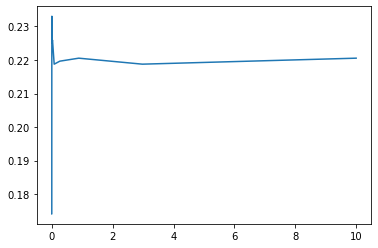

In [128]:
plt.figure()
plt.plot(c_values, a)

In [114]:
    for ci, c in enumerate(c_values):

        # define model
        model = sklearn.linear_model.LogisticRegression(C = c, \
                                                        multi_class='multinomial',\
                                                        solver='lbfgs', \
                                                        penalty='l2', \
                                                        n_jobs = 8 )
        predlabs_nest = np.zeros(np.shape(trnlabs))

        # looping over folds within training set, nested cross-validation
        for cvi2, cv2 in enumerate(np.unique(nest_cv_labs)):

            trninds2 = nest_cv_labs!=cv2
            tstinds2 = nest_cv_labs==cv2

            trndat2 = trndat[trninds2,:]
            tstdat2 = trndat[tstinds2,:]
            trnlabs2 = trnlabs[trninds2]
            tstlabs2 = trnlabs[tstinds2]

            print(ci, cvi2)
            model.fit(trndat2, trnlabs2)
            pred = model.predict(tstdat2)

            predlabs_nest[tstinds2] = pred

        acc_each_cval[ci] = np.mean(predlabs_nest==trnlabs)

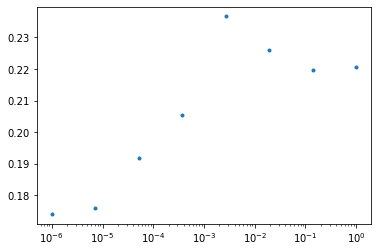

In [56]:
plt.figure()
plt.plot(c_values, acc_each_cval,'.')
plt.gca().set_xscale('log')

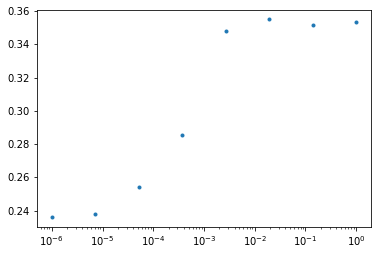

In [65]:
plt.figure()
plt.plot(c_values, acc_each_cval,'.')
plt.gca().set_xscale('log')

In [102]:
dat = np.random.normal(0,1,[80,20])
grid_labs = np.tile(np.arange(10),[8,])
cv_labs = np.repeat(np.arange(8), 10)
grid_labs, cv_labs

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]))

In [103]:
cv_obj = sklearn.model_selection.LeaveOneGroupOut()
cv_generator = cv_obj.split(dat, grid_labs, cv_labs)

# define model
model = sklearn.linear_model.LogisticRegressionCV(cv = cv_generator, \
                                                # C = c, \
                                                Cs = c_values, \
                                                multi_class='multinomial',\
                                                solver='lbfgs', \
                                                penalty='l2', \
                                                n_jobs = 8 )

model.fit(dat, grid_labs)
# pred = model.predict(dat)

LogisticRegressionCV(Cs=array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00]),
                     cv=<generator object BaseCrossValidator.split at 0x7fb4d23cf9d0>,
                     multi_class='multinomial', n_jobs=8)

In [112]:
allacc = np.zeros((len(np.unique(cv_labs)), len(c_values)))

for ci, c in enumerate(c_values):

    model = sklearn.linear_model.LogisticRegression(C = c, \
                                                    multi_class='multinomial',\
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = 8 )
    # predlabs = np.zeros(np.shape(grid_labs))
    
    for cvi, cv in enumerate(np.unique(cv_labs)):
    
        trninds = cv_labs!=cv
        tstinds = cv_labs==cv
        
        model.fit(dat[trninds,:], grid_labs[trninds])
        pred = model.predict(dat[tstinds,:])
        
        # predlabs[tstinds] = pred
        
        allacc[cvi, ci] = np.mean(pred==grid_labs[tstinds])
        

In [113]:
allacc

array([[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
       [0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1],
       [0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1],
       [0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.3],
       [0.1, 0.1, 0.1, 0.1, 0. , 0. , 0.2, 0.3],
       [0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]])

In [104]:
model.C_

array([0.13894955, 0.13894955, 0.13894955, 0.13894955, 0.13894955,
       0.13894955, 0.13894955, 0.13894955, 0.13894955, 0.13894955])

In [109]:
acc = model.scores_[0]
# n_folds x n_Cs
acc
# np.mean(acc, axis=0)

array([[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
       [0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.2, 0.1],
       [0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1],
       [0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.3],
       [0.1, 0.1, 0.1, 0.1, 0. , 0. , 0.2, 0.3],
       [0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]])

In [107]:
c_values[np.argmax(np.mean(acc, axis=0))]

0.1389495494373136

In [108]:
c_values

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00])

In [84]:
np.mean(pred==grid_labs)

0.9

In [63]:
# for cvi, cv in enumerate(np.unique(cv_labs)):
cvi = 0;
cv = np.unique(cv_labs)[cvi]

trninds = cv_labs!=cv
tstinds = cv_labs==cv

trndat = dat[trninds,:]
tstdat = dat[tstinds,:]
trnlabs = grid_labs[trninds]
tstlabs = grid_labs[tstinds]

# now going to do regularization parameter (c) selection
# this is based on training data only, for the current fold.
# cross-validate using leave-one-run-out (for just the training runs here)
nest_cv_labs = cv_labs[trninds]

# store which c value is best
acc_each_cval = np.zeros((len(c_values),))

for ci, c in enumerate(c_values):

    # define model
    model = sklearn.linear_model.LogisticRegression(C = c, \
                                                    multi_class='multinomial',\
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = 8 )
    predlabs_nest = np.zeros(np.shape(trnlabs))

    # looping over folds within training set, nested cross-validation
    for cvi2, cv2 in enumerate(np.unique(nest_cv_labs)):

        trninds2 = nest_cv_labs!=cv2
        tstinds2 = nest_cv_labs==cv2

        trndat2 = trndat[trninds2,:]
        tstdat2 = trndat[tstinds2,:]
        trnlabs2 = trnlabs[trninds2]
        tstlabs2 = trnlabs[tstinds2]

        print(ci, cvi2)
        model.fit(trndat2, trnlabs2)
        pred = model.predict(tstdat2)

        predlabs_nest[tstinds2] = pred

    acc_each_cval[ci] = np.mean(predlabs_nest==trnlabs)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31


KeyboardInterrupt: 

In [40]:
trndat2.shape

(320, 1866)

In [41]:
tstdat2.shape

(32, 1866)